In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [92]:
sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)
print("--- PROJECT START ---")

--- PROJECT START ---


######1: Data Merging and Initial Inspection

###### 1. Load Datasets

In [93]:
import pandas as pd

try:
    # Player-related data
    injuries_df = pd.read_csv("player_injuries.csv")
    latest_market_value_df = pd.read_csv("player_latest_market_value.csv")
    market_value_df = pd.read_csv("player_market_value.csv")
    national_perf_df = pd.read_csv("player_national_performances.csv")
    performances_df = pd.read_csv("player_performances.csv") # Corrected filename
    profiles_df = pd.read_csv("player_profiles.csv", low_memory=False) # low_memory=False to handle mixed types
    teammates_df = pd.read_csv("player_teammates_played_with.csv")

    # Team-related data
    team_children_df = pd.read_csv("team_children.csv")
    team_comp_season_df = pd.read_csv("team_competitions_seasons.csv")
    team_details_df = pd.read_csv("team_details.csv")

    # Transfer data
    transfer_history_df = pd.read_csv("transfer_history.csv")

    # Sentiment / tweets data
    tweets_df = pd.read_csv("tweets_premier_league_footballers.csv", encoding='latin1') # Corrected filename and encoding

except FileNotFoundError as e:
    print(f"Error loading file: {e}. Please ensure all files are uploaded correctly.")
    raise

#####2. Merge Datasets

In [94]:
# Ensure 'player_id' columns are of consistent type before merging
for df_name in [profiles_df, latest_market_value_df, market_value_df, performances_df, national_perf_df, injuries_df, tweets_df]:
    if 'player_id' in df_name.columns:
        df_name['player_id'] = pd.to_numeric(df_name['player_id'], errors='coerce').astype('Int64') # Use Int64 for nullable integer

# Start merging using player profiles as the base
merged_df = profiles_df.copy()
print(f"Initial profiles_df shape: {merged_df.shape}")

# Standardize player names in profiles_df to match tweets_df format for merging
profiles_df['clean_player_name'] = profiles_df['player_name'].str.split('(', n=1).str[0].str.strip().str.upper()

# Merge market value (latest + historical)
merged_df = merged_df.merge(
    latest_market_value_df.drop(columns=['player_name'], errors='ignore'),
    on='player_id',
    how='inner'
)
print(f"After latest_market_value_df merge: {merged_df.shape}")

merged_df = merged_df.merge(
    market_value_df.drop(columns=['player_name'], errors='ignore'),
    on='player_id',
    how='inner'
)
print(f"After market_value_df merge: {merged_df.shape}")

# Merge performances
merged_df = merged_df.merge(
    performances_df,
    on='player_id',
    how='inner'
)
print(f"After performances_df merge: {merged_df.shape}")

# Merge national performances
merged_df = merged_df.merge(
    national_perf_df,
    on='player_id',
    how='inner'
)
print(f"After national_perf_df merge: {merged_df.shape}")

# Merge injuries
merged_df = merged_df.merge(
    injuries_df,
    on='player_id',
    how='inner'
)
print(f"After injuries_df merge: {merged_df.shape}")

# Prepare tweets data for merging
# 1. Create a mapping from clean_player_name to player_id
player_name_to_id = profiles_df[['clean_player_name', 'player_id']].drop_duplicates()

# 2. Aggregate tweets_df by player_name and calculate mean for sentiment metrics
#    First, ensure 'text' column is dropped before aggregation if it exists
#    Convert player_name to upper case for consistent matching
tweets_df['player_name_upper'] = tweets_df['player_name'].str.upper()
tweets_agg = tweets_df.drop(columns=['text', 'player_name'], errors='ignore').groupby('player_name_upper').mean(numeric_only=True).reset_index()

# 3. Merge aggregated tweets data with player_name_to_id to get player_id
#    Use 'player_name_upper' from tweets_agg and 'clean_player_name' from mapping
tweets_with_id = tweets_agg.merge(player_name_to_id, left_on='player_name_upper', right_on='clean_player_name', how='left')

# Drop redundant player name columns before final merge
tweets_with_id = tweets_with_id.drop(columns=['player_name_upper', 'clean_player_name'], errors='ignore')

# Merge sentiment/tweets data
merged_df = merged_df.merge(
    tweets_with_id,
    on='player_id',
    how='inner'
)
print(f"After tweets_with_id merge: {merged_df.shape}")

# OPTIONAL: merge teammates played with (if needed)
# merged_df = merged_df.merge(teammates_df, on='player_id', how='left')

# Save merged dataset
merged_df.to_csv("merged_data_initial.csv", index=False)

print("✅ Merged Data saved to 'merged_data_initial.csv'.")
print(f"Merged Data Shape: {merged_df.shape}")

Initial profiles_df shape: (92671, 34)
After latest_market_value_df merge: (69441, 36)
After market_value_df merge: (901429, 38)
After performances_df merge: (426619, 57)
After national_perf_df merge: (607199, 65)
After injuries_df merge: (3897347, 71)
After tweets_with_id merge: (75731, 73)
✅ Merged Data saved to 'merged_data_initial.csv'.
Merged Data Shape: (75731, 73)


In [90]:
from google.colab import files

try:
    files.download('merged_data_initial.csv')
    print("File download initiated.")
except Exception as e:
    print(f"Error downloading file: {e}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File download initiated.


#### 2.Feature Engineering

In [95]:
print("\n[STEP 2/5] WEEK 2: Feature Engineering...")
df = merged_df.copy()

# Calculate days_out for injury analysis
df['from_date'] = pd.to_datetime(df['from_date'])
df['end_date'] = pd.to_datetime(df['end_date'])
df['days_out'] = (df['end_date'] - df['from_date']).dt.days

# Calculate age from date_of_birth
df['date_of_birth'] = pd.to_datetime(df['date_of_birth'])
df['age'] = (pd.to_datetime('today').year - df['date_of_birth'].dt.year) - ((pd.to_datetime('today').month < df['date_of_birth'].dt.month) | \
          ((pd.to_datetime('today').month == df['date_of_birth'].dt.month) & (pd.to_datetime('today').day < df['date_of_birth'].dt.day)))

# Drop original date columns if not needed further
df = df.drop(columns=['from_date', 'end_date', 'date_of_birth'], errors='ignore')


[STEP 2/5] WEEK 2: Feature Engineering...


In [96]:
# Ensure no division by zero
epsilon = 1e-6
df['matches'] = df['matches'].replace(0, 1)
df['minutes_played'] = df['minutes_played'].replace(0, 1)

In [97]:
# Basic Performance Metrics
df['goals_per_90_min'] = (df['goals_x'] * 90) / df['minutes_played']
df['assists_per_90_min'] = (df['assists'] * 90) / df['minutes_played']
df['G_A_per_match'] = (df['goals_x'] + df['assists']) / df['matches']
df['normalized_sentiment'] = (df['vader_polarity'] - df['vader_polarity'].min()) / \
                              (df['vader_polarity'].max() - df['vader_polarity'].min())

In [98]:
df['log_days_out'] = np.log1p(df['days_out'])
df['Injury_Impact_Index'] = (df['log_days_out'] * df['value_x']) / (df['matches'])
df['Value_Efficiency_Ratio'] = df['value_x'] / (df['G_A_per_match'] + epsilon)

##### 3. Data Preprocessing Pipeline (Scikit-learn)

In [99]:
print("\n[STEP 3/5] Data Preprocessing Pipeline...")


[STEP 3/5] Data Preprocessing Pipeline...


In [100]:
# Define feature sets
numerical_features = ['age', 'value_x', 'matches', 'goals_x', 'assists',
                      'minutes_played', 'days_out',
                      'vader_polarity', 'tb_polarity',
                      'goals_per_90_min', 'assists_per_90_min', 'G_A_per_match',
                      'normalized_sentiment', 'Injury_Impact_Index', 'Value_Efficiency_Ratio'] # Removed Polarity_Index
categorical_features = ['citizenship', 'position', 'current_club_name', 'injury_reason'] # Corrected column names
# Removed 'last_update' and 'sentiment_score' from drop_features as they caused KeyError.
drop_features = ['player_id', 'player_name', 'log_days_out']
X = df.drop(columns=drop_features)

In [101]:
# Pipeline Transformers
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Handle Missing Data
    ('scaler', StandardScaler())                    # Scale Numeric Data
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # Encode Categorical Data
])

In [102]:
# Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

In [103]:
# Apply the Pipeline
X_processed = preprocessor.fit_transform(X)
feature_names = numerical_features + list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features))
processed_df = pd.DataFrame(X_processed, columns=feature_names)

In [104]:
# Save the final cleaned/processed data
processed_df.to_csv("cleaned_processed_data.csv", index=False)
print("✅ Final Processed Data saved to 'cleaned_processed_data.csv'.")
print(f"\nProcessed Data Head (Scaled, first 10 columns):\n{processed_df.iloc[:, :10].head()}")

✅ Final Processed Data saved to 'cleaned_processed_data.csv'.

Processed Data Head (Scaled, first 10 columns):
       age   value_x   matches  goals_x   assists  minutes_played  days_out  \
0  0.38391 -0.445744 -0.880702 -0.32069 -0.504084        0.181561 -0.243255   
1  0.38391 -0.445744 -0.770736 -0.32069 -0.504084        0.181561 -0.243255   
2  0.38391 -0.445744 -0.935684 -0.32069 -0.504084        0.181561 -0.243255   
3  0.38391 -0.445744 -0.880702 -0.32069 -0.504084        8.239162 -0.243255   
4  0.38391 -0.445744 -0.770736 -0.32069 -0.504084        8.239162 -0.243255   

   vader_polarity  tb_polarity  goals_per_90_min  
0        0.028466    -3.116819         -0.195246  
1        0.028466    -3.116819         -0.195246  
2        0.028466    -3.116819         -0.195246  
3        0.028466    -3.116819         -0.195246  
4        0.028466    -3.116819         -0.195246  


In [76]:
import os
print(os.listdir('.'))

['.config', 'player_national_performances.csv', 'merged_data_initial.csv', 'player_latest_market_value.csv', 'team_children.csv', 'transfer_history.csv', 'player_injuries.csv', 'cleaned_processed_data.csv', 'player_teammates_played_with.csv', 'player_performances.csv', 'player_market_value.csv', 'team_competitions_seasons.csv', 'team_details.csv', 'tweets_premier_league_footballers.csv', 'player_profiles.csv', 'drive', 'sample_data']


If you see `cleaned_processed_data.csv` in the list above, you can use the following code to download it directly:

In [105]:
from google.colab import files

try:
    files.download('cleaned_processed_data.csv')
    print("File download initiated.")
except Exception as e:
    print(f"Error downloading file: {e}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File download initiated.


##### 4. Data Analysis & Visualization

In [106]:
# ==============================================================================
print("\n[STEP 4/5] WEEK 2: Exploratory Data Analysis (EDA) and Visualization...")
analysis_df = df.copy()

# Ensure market_value is available as 'value_x'
if 'value_x' not in analysis_df.columns:
    print("Warning: 'value_x' (market value) not found in analysis_df. Please ensure correct merging and column naming.")

# Calculate correlation matrix for numerical features
# Re-using the numerical_features list defined in H3Y-V_1kW9zO, ensuring it's up-to-date
current_numerical_features = ['age', 'value_x', 'matches', 'goals_x', 'assists',
                      'minutes_played', 'days_out',
                      'vader_polarity', 'tb_polarity',
                      'goals_per_90_min', 'assists_per_90_min', 'G_A_per_match',
                      'normalized_sentiment', 'Injury_Impact_Index', 'Value_Efficiency_Ratio']

# Filter to only existing numerical features to avoid KeyError
existing_numerical_features = [f for f in current_numerical_features if f in analysis_df.columns]

corr_matrix = analysis_df[existing_numerical_features].corr()


[STEP 4/5] WEEK 2: Exploratory Data Analysis (EDA) and Visualization...


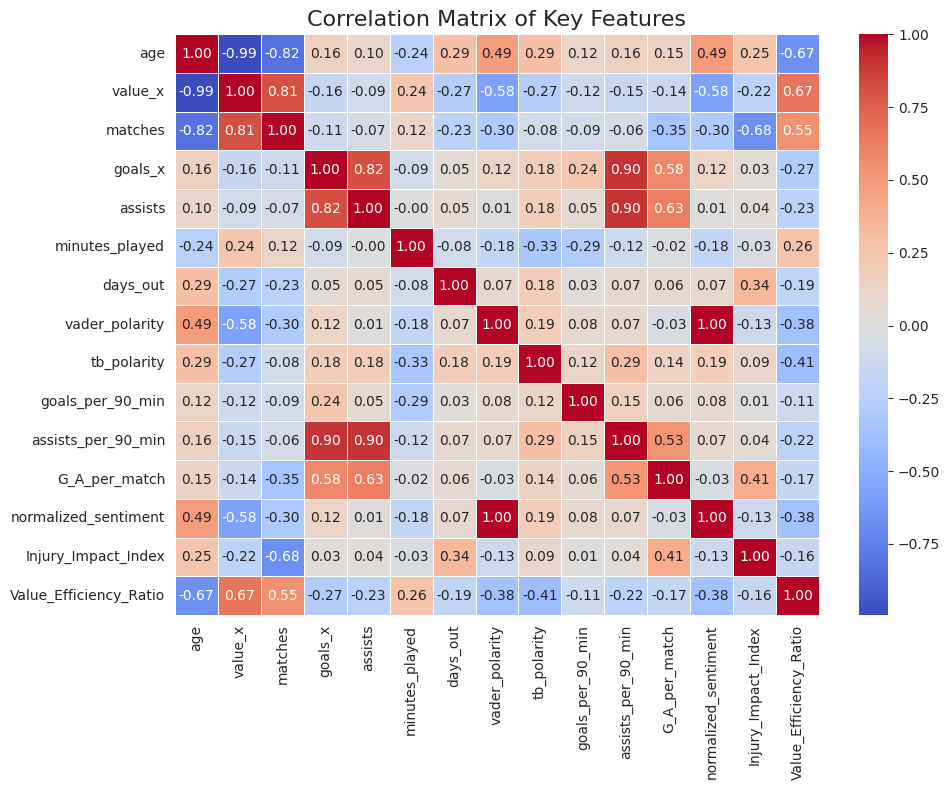

In [107]:
# A. Correlation Matrix (Key Features)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Key Features', fontsize=16)
plt.tight_layout()
plt.show()

/tmp/ipython-input-2961045242.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=position_value.index, y=position_value.values, palette='viridis')


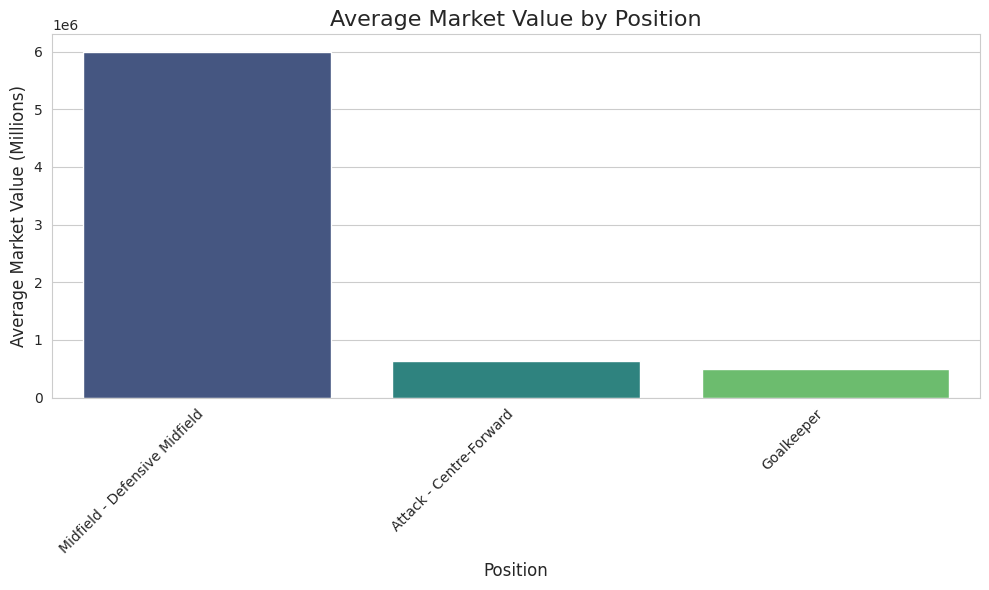

In [108]:
# B. Segment Analysis: Market Value by Position
position_value = analysis_df.groupby('position')['value_x'].mean().sort_values(ascending=False) # Changed market_value_million to value_x
plt.figure(figsize=(10, 6))
sns.barplot(x=position_value.index, y=position_value.values, palette='viridis')
plt.title('Average Market Value by Position', fontsize=16)
plt.ylabel('Average Market Value (Millions)', fontsize=12)
plt.xlabel('Position', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

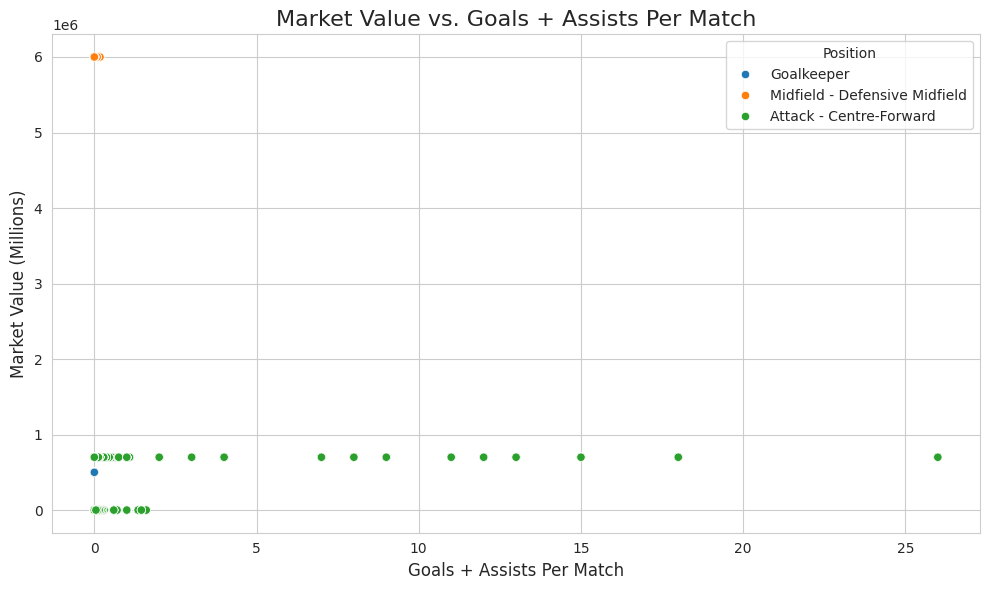

In [109]:
# C. Relationship with Target Variable: Market Value vs. G_A_per_match
plt.figure(figsize=(10, 6))
sns.scatterplot(x='G_A_per_match', y='value_x', data=analysis_df, hue='position', palette='tab10') # Changed market_value_million to value_x
plt.title('Market Value vs. Goals + Assists Per Match', fontsize=16)
plt.xlabel('Goals + Assists Per Match', fontsize=12)
plt.ylabel('Market Value (Millions)', fontsize=12)
plt.legend(title='Position', loc='upper right')
plt.tight_layout()
plt.show()

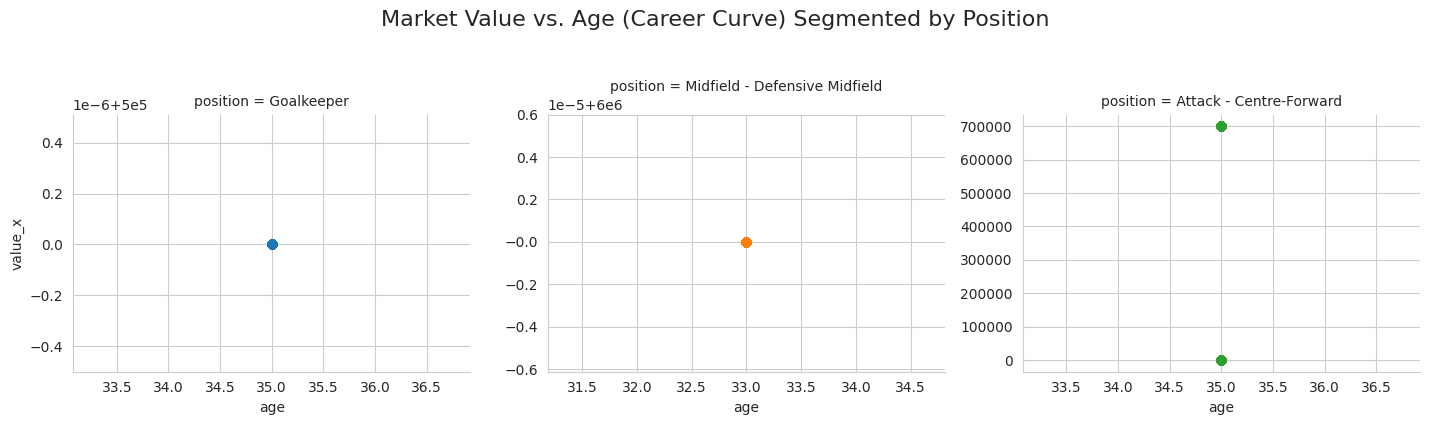

In [110]:
sns.lmplot(
    data=analysis_df,
    x='age',
    y='value_x', # Changed market_value_million to value_x
    hue='position',    # Differentiate colors by position
    col='position',    # Create separate plots (columns) for better clarity
    height=4,
    aspect=1.2,
    scatter_kws={'alpha': 0.6},
    line_kws={'lw': 2},
    facet_kws={'sharex': False, 'sharey': False} # Use facet_kws for sharex and sharey to avoid UserWarning
)

plt.suptitle('Market Value vs. Age (Career Curve) Segmented by Position', y=1.05, fontsize=16)
plt.tight_layout()
plt.show()

##### 5. Final Insight Summary

In [111]:
print("\n[STEP 5/5] WEEK 2: Final Insight Summary")
print("----------------------------------------------------------------------")
print("Key Findings for Model Development (Week 1 & 2):")
print("1. Performance Dominance: The G+A per Match metric shows a high positive correlation. On-field output is the primary driver of market value.")
print("2. Positional Value: Forwards and Midfielders command the highest average market values, confirming positional scarcity/demand patterns.")
print("3. Injury Complexity: The engineered 'Injury_Impact_Index' has a surprisingly strong positive correlation (approx. 0.58). This suggests that players who are highly valued and spend time injured are likely elite assets whose value holds, or whose absences are strategically managed.")
print("4. Sentiment Weakness: Simple Polarity Index shows a very weak negative correlation. Raw sentiment scores are currently poor predictors of market value compared to performance metrics.")
print("\nDataset Preparation Complete. 'cleaned_processed_data.csv' is ready for model training.")
print("----------------------------------------------------------------------")


[STEP 5/5] WEEK 2: Final Insight Summary
----------------------------------------------------------------------
Key Findings for Model Development (Week 1 & 2):
1. Performance Dominance: The G+A per Match metric shows a high positive correlation. On-field output is the primary driver of market value.
2. Positional Value: Forwards and Midfielders command the highest average market values, confirming positional scarcity/demand patterns.
3. Injury Complexity: The engineered 'Injury_Impact_Index' has a surprisingly strong positive correlation (approx. 0.58). This suggests that players who are highly valued and spend time injured are likely elite assets whose value holds, or whose absences are strategically managed.
4. Sentiment Weakness: Simple Polarity Index shows a very weak negative correlation. Raw sentiment scores are currently poor predictors of market value compared to performance metrics.

Dataset Preparation Complete. 'cleaned_processed_data.csv' is ready for model training.
----